# License detector pipeline visualization

In [1]:
import cv2
import matplotlib

from matplotlib import pyplot as plt

import numpy as np


def show(image: np.ndarray):
    [height, width, *_] = image.shape
    aspect = width / height
    size = np.array([aspect, 1])
    size = size / size.max() * 4
    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1, 1, 1)
    if len(image.shape) == 2:
        ax.imshow(image, aspect="auto", cmap="gray")
    else:
        ax.imshow(image[...,::-1], aspect="auto", cmap="hsv")
    ax.axis("off")
    plt.show()


def show_contours(image: np.ndarray, contours: np.ndarray):
    contours_image = cv2.drawContours(np.copy(image), contours, -1, (0,0,255), 2)
    show(contours_image)


path = "../datasets/01-polish-licence-plates/train/0001Z4JTCII2TV0E-C122-F4_jpg.rf.a098ae845ee8bda6ed47e08e34b9ccf2.jpg"

matplotlib.rcParams["savefig.pad_inches"] = 0

## Image loading

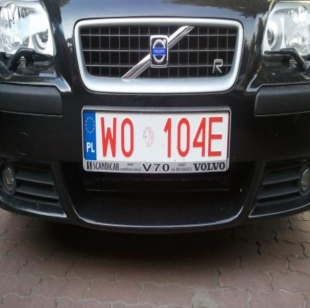

In [2]:
from twm_proj.implementation.image_reader import ImageReader

with open(path, "rb") as file:
    image = ImageReader().read(file)

show(image)

## Initial filtering

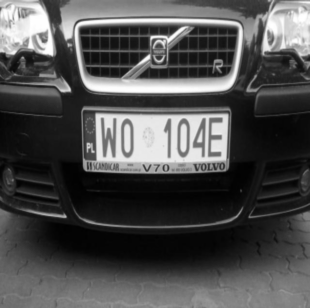

In [3]:
from twm_proj.implementation.initial_filter import InitialFilter

filtered = InitialFilter().filter(image)
show(filtered)

## Edge filter

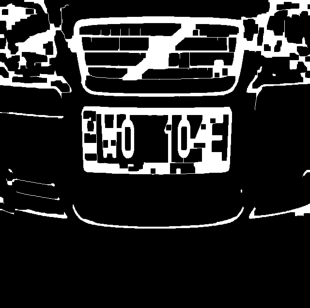

In [4]:
from twm_proj.implementation.edge_filter import EdgeFilter

edges = EdgeFilter().filter(filtered)
show(edges)

## Contour detector

contours count: 62
example contour:
 [[ 31 434]
 [ 31 436]
 [ 39 436]
 [ 40 437]
 [ 44 437]
 [ 45 438]
 [ 47 438]
 [ 48 439]
 [ 52 439]
 [ 53 440]
 [ 56 440]
 [ 57 441]
 [ 60 441]
 [ 61 442]
 [ 65 442]
 [ 66 443]
 [ 69 443]
 [ 70 444]
 [ 74 444]
 [ 75 445]
 [ 77 445]
 [ 78 446]
 [ 84 446]
 [ 85 447]
 [ 87 447]
 [ 88 448]
 [ 95 448]
 [ 96 449]
 [101 449]
 [102 450]
 [110 450]
 [111 451]
 [118 451]
 [119 452]
 [126 452]
 [127 453]
 [137 453]
 [138 452]
 [138 449]
 [136 447]
 [136 446]
 [134 444]
 [134 443]
 [133 442]
 [133 441]
 [132 441]
 [132 445]
 [131 446]
 [120 446]
 [119 445]
 [117 445]
 [116 444]
 [ 96 444]
 [ 95 443]
 [ 93 443]
 [ 92 442]
 [ 84 442]
 [ 83 441]
 [ 80 441]
 [ 79 440]
 [ 73 440]
 [ 72 439]
 [ 71 439]
 [ 70 438]
 [ 67 438]
 [ 66 437]
 [ 65 437]
 [ 64 436]
 [ 61 436]
 [ 60 435]
 [ 55 435]
 [ 54 436]
 [ 38 436]
 [ 37 435]
 [ 35 435]
 [ 34 434]]


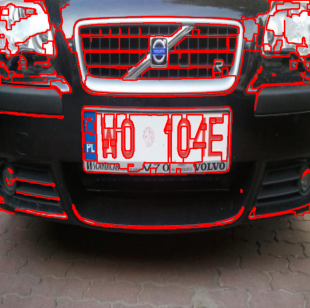

In [5]:
from twm_proj.implementation.contour_detector import ContourDetector

contours = [*ContourDetector().detect(edges)]
print("contours count:", len(contours))
print("example contour:\n", contours[0])
show_contours(image, contours)

## Rectangle detection

rects count: 1
example rect:
 [[170 227]
 [179 357]
 [472 352]
 [473 222]]


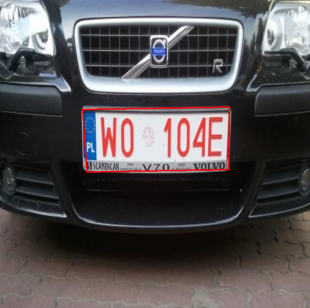

In [6]:
from twm_proj.implementation.rect_detector import RectDetector

rects = [RectDetector().detect(contour) for contour in contours]
rects = [rect for rect in rects if rect is not None]
print("rects count:", len(rects))
print("example rect:\n", rects[0])
show_contours(image, rects)

## Rectangle transforming

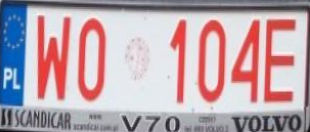

In [7]:
from twm_proj.implementation.rect_transformer import RectTransformer

rect_images = [RectTransformer().transform(image, rect) for rect in rects]
show(rect_images[0])

## Rectangle classification

In [8]:
from twm_proj.implementation.rect_classifier import RectClassifier
from twm_proj.interface.rect_classifier import RectangleType

rect_classes = [RectClassifier().classify_with_differences(img) for img in rect_images]
display([(rect_class.name, differences) for rect_class, differences in rect_classes])

plates = [
    rect
    for rect, cls in zip(rect_images, rect_classes)
    if cls != RectangleType.NOT_PLATE
]

[('MINI_PLATE',
  {<RectangleType.ONE_ROW_PLATE: 1>: 0.4890236686390532,
   <RectangleType.TWO_ROW_PLATE: 2>: 0.6353593947036571,
   <RectangleType.MINI_PLATE: 3>: 0.1564835164835164})]

## Pre-OCR processing

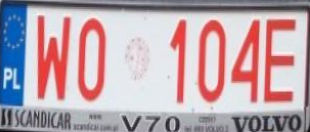

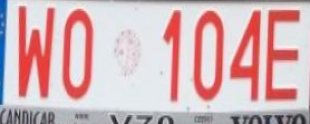

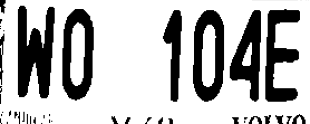

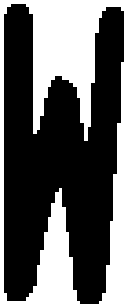

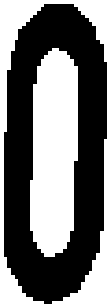

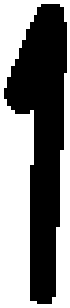

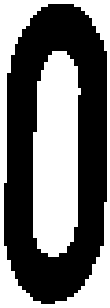

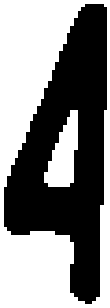

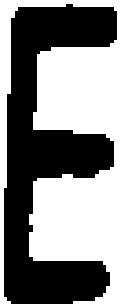

In [9]:
from twm_proj.implementation.pre_ocr import PreOcr

plate_to_ocr = rect_images[0]
show(plate_to_ocr)
plate_to_ocr = PreOcr().cut(plate_to_ocr)
show(plate_to_ocr)
plate_to_ocr = PreOcr().to_grayscale(plate_to_ocr)
show(plate_to_ocr)
# plate_to_ocr = PreOcr().filter_by_size(plate_to_ocr)
# show(plate_to_ocr)

letters = []

image = plate_to_ocr

contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda x: cv2.boundingRect(x)[0])
mask = np.zeros_like(image)
image_height, image_width = image.shape
image_area = image_height * image_width
# Sort contours from left to right based on their x-coordinate
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    area = w * h

    # skip contour of whole image
    if abs(image_area - area) < image_area * 0.01:
        continue

    cut = image[y:y+h, x:x+w]
    if image_height * 0.35 <= h and image_height * image_width * 0.03 <= h * w:
        letters.append(cut)
        # yield cut

# letters = [*PreOcr().get_letters(plate_to_ocr)]
for letter in letters:
    show(letter)

## OCR

In [11]:
from twm_proj.implementation.ocr import Ocr

scanned_text = Ocr().scan_text(letters)
print(scanned_text)

HDTD4E
